In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes


100%|██████████| 170M/170M [00:19<00:00, 8.88MB/s]


In [3]:
class FusionModel(nn.Module):
    def __init__(self, num_classes=10):
        super(FusionModel, self).__init__()

        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()

        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()

        self.classifier = nn.Linear(512 + 1280, num_classes)

    def forward(self, x):
        res_features = self.resnet(x)
        mob_features = self.mobilenet(x)

        fused = torch.cat((res_features, mob_features), dim=1)
        output = self.classifier(fused)
        return output


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 94.0MB/s]


In [5]:
epochs = 5
train_loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    train_loss_history.append(running_loss)
    train_acc_history.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch [1/5], Loss: 270.5660, Accuracy: 88.08%
Epoch [2/5], Loss: 137.2323, Accuracy: 94.05%
Epoch [3/5], Loss: 92.2414, Accuracy: 95.90%
Epoch [4/5], Loss: 73.8577, Accuracy: 96.74%
Epoch [5/5], Loss: 59.6271, Accuracy: 97.36%


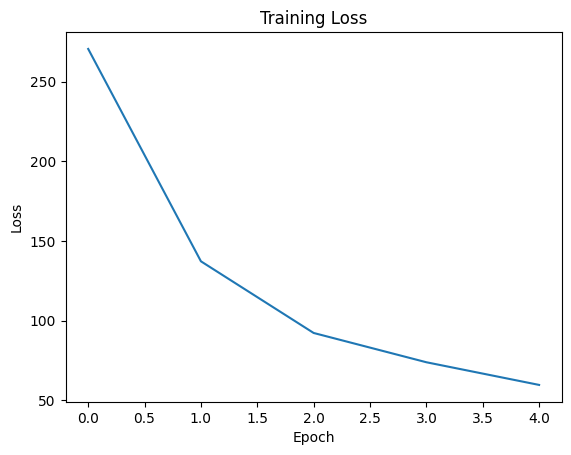

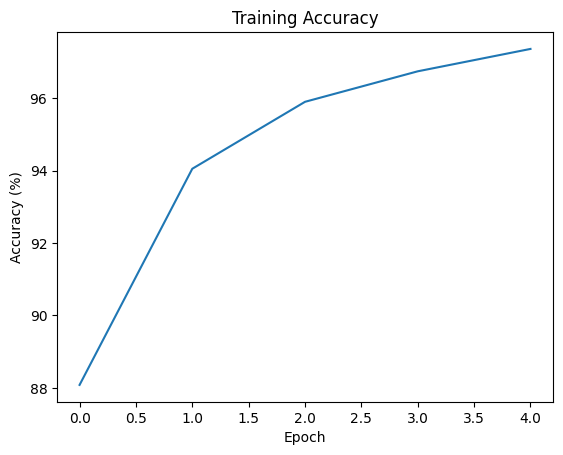

In [6]:
plt.figure()
plt.plot(train_loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(train_acc_history)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()


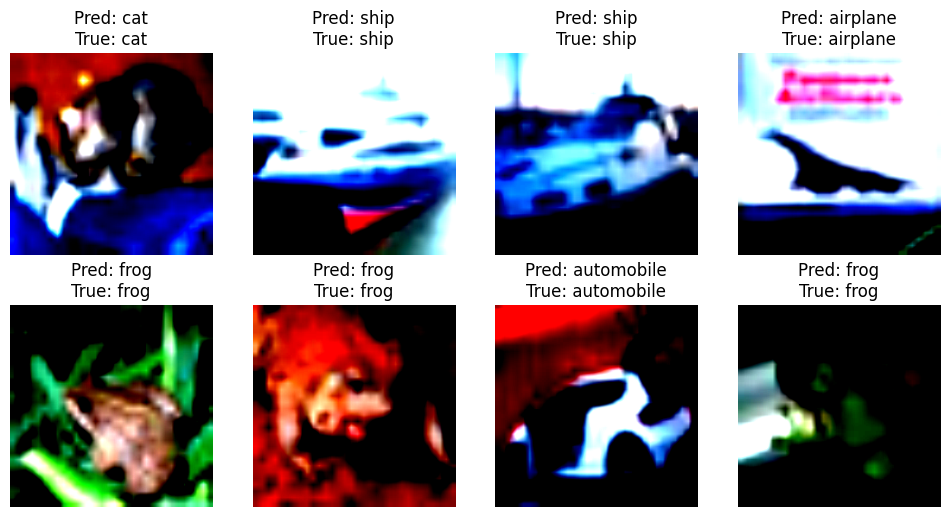

In [7]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = images[i].cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis("off")
plt.show()
